In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# better display of review text in dataframes
pd.set_option('display.max_colwidth', None) 

# Seaborn options
sns.set(style="whitegrid", font_scale=1.4)

# Auto reload modules
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
assert tf.__version__ >= "2.0"

In [3]:
# This cell is only here as a bug fix when running RNN on my GPU
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Prepare data

## Load dataset

In [8]:
import pickle

PICKLE_PATH = "allocine_dataset/data/allocine_dataset.pickle"

with open(PICKLE_PATH, 'rb') as reader:
    data = pickle.load(reader)

# Reviews need to be tokenized
train_reviews = np.array(data["train_set"]['review'])
val_reviews = np.array(data["val_set"]['review'])
test_reviews = np.array(data["test_set"]['review'])

# Used to train fit tokenizer
#all_reviews = np.concatenate((train_reviews, val_reviews, test_reviews), axis=0)

train_labels = data["train_set"]['polarity']
val_labels = data["val_set"]['polarity']
test_labels = data["test_set"]['polarity']
class_names = data['class_names']

## Preprocess dataset

### Tokenize

We train the tokenizer on the reviews of the train set

In [9]:
MAX_NB_WORDS = 20000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=MAX_NB_WORDS,
    oov_token="<unk>",
)
tokenizer.fit_on_texts(train_reviews)

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

Found 186308 unique tokens.


In [10]:
train_reviews_tokenized = tokenizer.texts_to_sequences(train_reviews)
val_reviews_tokenized = tokenizer.texts_to_sequences(val_reviews)
test_reviews_tokenized = tokenizer.texts_to_sequences(test_reviews)

In [11]:
some_review = train_reviews_tokenized[0]
some_review[:15]

[45, 68, 4664, 17, 77, 15081, 7, 80, 9, 8746, 2505, 249, 439, 17, 1181]

In [12]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
" ".join([index_to_word[i] for i in some_review[:15]])

"si vous cherchez du cinéma abrutissant à tous les étages n'ayant aucune peur du cliché"

Average length: 91.5
Max length: 389


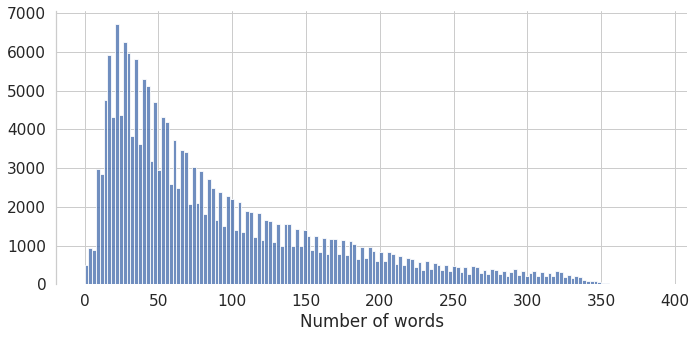

In [13]:
reviews_len = [len(s) for s in train_reviews_tokenized+val_reviews_tokenized+test_reviews_tokenized]
print("Average length: {:.1f}".format(np.mean(reviews_len)))
print("Max length: {}".format(max(reviews_len)))

plt.figure(figsize=(10,5))
ax = sns.distplot(reviews_len, bins=150, kde=False, hist_kws=dict(alpha=0.8))
ax.set(xlabel='Number of words')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig = ax.get_figure()
fig.savefig('img/word-vectors/number_of_words.png', dpi=200)

In [10]:
# This assert is likely to fail
assert(reviews_len.count(0) == 0)

AssertionError: 

### Remove empty sequences

Important not to have empty tensors: https://github.com/tensorflow/tensorflow/issues/33148

In [14]:
def remove_empty_sequences(reviews, labels):
    reviews_not_empty = []
    labels_not_empty = []
    removed = 0
    for x, y in zip(reviews, labels):
        if len(x) > 0:
            reviews_not_empty.append(x)
            labels_not_empty.append(y)
        else:
            removed += 1
    #print("Removed {} sequences !".format(removed))
    return reviews_not_empty, labels_not_empty

In [15]:
print('Removing {} empty sequences'.format(reviews_len.count(0)))

train_reviews_tokenized, train_labels = remove_empty_sequences(
    train_reviews_tokenized, train_labels
)

val_reviews_tokenized, val_labels = remove_empty_sequences(
    val_reviews_tokenized, val_labels
)

test_reviews_tokenized, test_labels = remove_empty_sequences(
    test_reviews_tokenized, test_labels
)

# Verify
reviews_len = [len(s) for s in train_reviews_tokenized+val_reviews_tokenized+test_reviews_tokenized]
assert(reviews_len.count(0) == 0)

Removing 8 empty sequences


### Padding

Then we pad short sequences with zeros until they reach a fixed length. Long sequences are also truncated.

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LENGTH_SEQ = 350 #

X_train = pad_sequences(
    train_reviews_tokenized, 
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_val = pad_sequences(
    val_reviews_tokenized, 
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_test = pad_sequences(
    test_reviews_tokenized, 
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

print('Shape of X_train tensor:', X_train.shape)
print('Shape of X_val tensor:', X_val.shape)
print('Shape of X_test tensor:', X_test.shape)

Shape of X_train tensor: (159993, 350)
Shape of X_val tensor: (19999, 350)
Shape of X_test tensor: (20000, 350)


### Labels

In [17]:
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

### Preprocessing pipeline

In order to carry out the preprocessing phase more efficiently, we can define a Scikit-Learn transformer.

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

class SequencePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, max_nbr_words, max_seq_length):
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(
            num_words=max_nbr_words,
            oov_token="<unk>",
        )
        self.max_seq_length = max_seq_length

    # the arguments are ignored anyway, so we make them optional
    def fit(self, X):
        self.tokenizer.fit_on_texts(X)

    def transform(self, X, y):
        # 1. Tokenize
        X_tokenized = self.tokenizer.texts_to_sequences(X)
        # 2. Remove empty sequences
        X_not_empty, y_not_empty = remove_empty_sequences(X_tokenized, y)
        # 3. Pad
        X_padded = tf.keras.preprocessing.sequence.pad_sequences(
            X_not_empty, 
            maxlen=self.max_seq_length,
            padding='post'
        )
        # 4. labels
        y_array = np.array(y_not_empty)
        return X_padded, y_array     
    
    def fit_transform(self, X, y):
        self.fit(X)
        return self.transform(X, y)

# fastText

## Model

First we train an model which classify reviews based on the average vector of their embeddings.

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

# Hyperparameters
max_features = MAX_NB_WORDS
embedding_dim = 128

model = Sequential(name='fasttext')
model.add(Embedding(max_features, embedding_dim,
                           input_shape=[None]),)
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [53]:
initial_weights = model.get_weights()
model.summary()

Model: "fasttext"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 2,560,129
Trainable params: 2,560,129
Non-trainable params: 0
_________________________________________________________________


## Training

In [25]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='data/word-vectors/fasttext_weights.hdf5',
    save_best_only=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, batch_size=128, 
    callbacks=[checkpointer], verbose=1)

Train on 159993 samples, validate on 19999 samples
Epoch 1/10
159872/159993 [============================>.] - ETA: 0s - loss: 0.4704 - accuracy: 0.8224
Epoch 00001: val_loss improved from inf to 0.30085, saving model to data/word-vectors/fasttext_weights.hdf5
159993/159993 [==============================] - 27s 171us/sample - loss: 0.4703 - accuracy: 0.8225 - val_loss: 0.3009 - val_accuracy: 0.9060
Epoch 2/10
159872/159993 [============================>.] - ETA: 0s - loss: 0.2559 - accuracy: 0.9119
Epoch 00002: val_loss improved from 0.30085 to 0.22888, saving model to data/word-vectors/fasttext_weights.hdf5
159993/159993 [==============================] - 27s 170us/sample - loss: 0.2558 - accuracy: 0.9119 - val_loss: 0.2289 - val_accuracy: 0.9203
Epoch 3/10
159872/159993 [============================>.] - ETA: 0s - loss: 0.2065 - accuracy: 0.9257
Epoch 00003: val_loss improved from 0.22888 to 0.20960, saving model to data/word-vectors/fasttext_weights.hdf5
159993/159993 [============

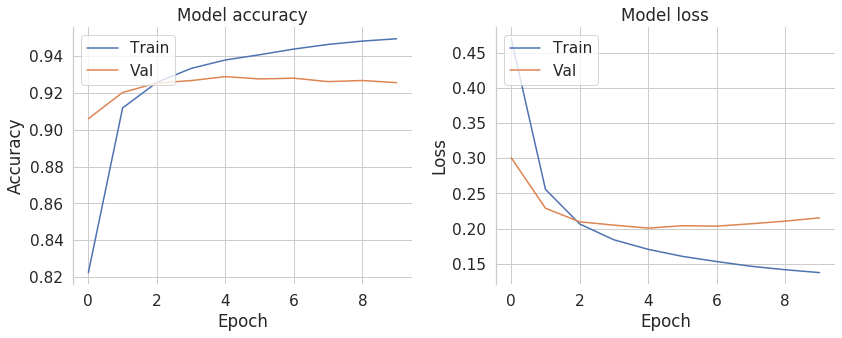

In [26]:
from utils import plot_training_curves

fig = plot_training_curves(history)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/word-vectors/fasttext_training.png', dpi=200)

In [27]:
from sklearn import metrics

probas = model.predict(X_val)
y_pred = (probas > 0.5).astype(np.int)

print("Val Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_val, y_pred)))
print("Val F1-Score: {:.2f}".format(100 * metrics.f1_score(y_val, y_pred)))

Val Accuracy: 92.89
Val F1-Score: 92.74


This simple technique works surprisingly well on our task !

## Testing

In [54]:
model.load_weights('data/word-vectors/fasttext_weights.hdf5')

probas = model.predict(X_test)
y_pred = (probas > 0.5).astype(np.int)

In [29]:
print("Test Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(100 * metrics.f1_score(y_test, y_pred)))
print()

report = metrics.classification_report(
    y_test, y_pred, 
    target_names=class_names.values()
)
print(report)

Test Accuracy: 92.92
Test F1-Score: 92.58

              precision    recall  f1-score   support

    Negative       0.93      0.94      0.93     10408
    Positive       0.93      0.92      0.93      9592

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



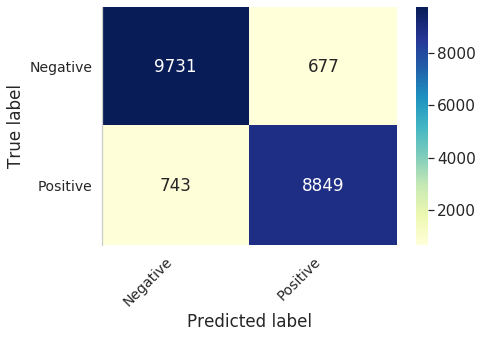

In [66]:
from sklearn.metrics import confusion_matrix
from utils import print_confusion_matrix

conf_mx = confusion_matrix(y_test, y_pred)

fig = print_confusion_matrix(
    conf_mx, 
    class_names.values(), 
    figsize=(7,5)
)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/word-vectors/fastext_test_confusion_mx.png', dpi=200)

## Accuracy vs Training data

In [45]:
from sklearn.base import BaseEstimator

class EarlyStoppingModel(BaseEstimator):
    def __init__(self, keras_model, max_epoches, batch_size, validation_data):
        self.model = keras_model
        self.max_epoches = max_epoches
        self.batch_size = batch_size
        self.validation_data = validation_data
        
    def fit(self, X, y):
        # Defines early stopper
        early_stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', mode='auto', patience=3,
            verbose=1, restore_best_weights=True
        )
        
        # Train model on data subset
        self.model.fit(
            X, y,
            validation_data=self.validation_data,
            epochs=self.max_epoches, 
            batch_size=self.batch_size,
            callbacks=[early_stopper], 
            verbose=2
        )        
        return self
    
    def predict(self, X):        
        probas = self.model.predict(X)
        y_pred = (probas > 0.5).astype(np.int)
        return y_pred

In [16]:
from sklearn import metrics 

def accuracy_vs_training_data(keras_model, initial_weights, 
                              preprocessor, sizes,
                              train_reviews, train_labels,
                              val_reviews, val_labels,
                              test_reviews, test_labels):
    test_accuracies = []
    for size in sizes:        
        # Preprocess data
        X_train, y_train = preprocessor.fit_transform(
            train_reviews[:size], train_labels[:size]
        )
        X_val, y_val = preprocessor.transform(val_reviews, val_labels)
        X_test, y_test = preprocessor.transform(test_reviews, test_labels)
        
        # Reset weights to initial value
        keras_model.set_weights(initial_weights)
        best_model = EarlyStoppingModel(
            keras_model, max_epoches=100, batch_size=64,
            validation_data=(X_val, y_val)
        )
        
        # Train model
        best_model.fit(X_train, y_train)
        
        # Evaluate on test set
        y_pred = best_model.predict(X_test)
        test_acc = metrics.accuracy_score(y_test, y_pred)
        test_accuracies.append(test_acc)
        
    return test_accuracies        

In [61]:
sizes = [int(p) for p in np.geomspace(1000, 160000, 10)]
preprocessor = SequencePreprocessor(MAX_NB_WORDS, MAX_LENGTH_SEQ)

test_accuracies = accuracy_vs_training_data(
    model, initial_weights, 
    preprocessor, sizes,
    train_reviews, train_labels,
    val_reviews, val_labels,
    test_reviews, test_labels
)

Train on 1000 samples, validate on 19999 samples
Epoch 1/100
1000/1000 - 1s - loss: 0.6925 - accuracy: 0.5100 - val_loss: 0.6912 - val_accuracy: 0.5379
Epoch 2/100
1000/1000 - 1s - loss: 0.6894 - accuracy: 0.5430 - val_loss: 0.6896 - val_accuracy: 0.5413
Epoch 3/100
1000/1000 - 1s - loss: 0.6873 - accuracy: 0.5420 - val_loss: 0.6881 - val_accuracy: 0.5408
Epoch 4/100
1000/1000 - 1s - loss: 0.6839 - accuracy: 0.5810 - val_loss: 0.6860 - val_accuracy: 0.5734
Epoch 5/100
1000/1000 - 1s - loss: 0.6801 - accuracy: 0.6110 - val_loss: 0.6839 - val_accuracy: 0.5750
Epoch 6/100
1000/1000 - 1s - loss: 0.6761 - accuracy: 0.6380 - val_loss: 0.6813 - val_accuracy: 0.5894
Epoch 7/100
1000/1000 - 1s - loss: 0.6709 - accuracy: 0.6440 - val_loss: 0.6783 - val_accuracy: 0.5893
Epoch 8/100
1000/1000 - 1s - loss: 0.6649 - accuracy: 0.6540 - val_loss: 0.6748 - val_accuracy: 0.6007
Epoch 9/100
1000/1000 - 1s - loss: 0.6582 - accuracy: 0.6870 - val_loss: 0.6709 - val_accuracy: 0.6293
Epoch 10/100
1000/1000 -

Epoch 80/100
1000/1000 - 1s - loss: 0.1061 - accuracy: 0.9880 - val_loss: 0.3907 - val_accuracy: 0.8443
Epoch 81/100
1000/1000 - 1s - loss: 0.1037 - accuracy: 0.9900 - val_loss: 0.3895 - val_accuracy: 0.8451
Epoch 82/100
1000/1000 - 1s - loss: 0.1015 - accuracy: 0.9900 - val_loss: 0.3899 - val_accuracy: 0.8422
Epoch 83/100
1000/1000 - 1s - loss: 0.1001 - accuracy: 0.9900 - val_loss: 0.3891 - val_accuracy: 0.8428
Epoch 84/100
1000/1000 - 1s - loss: 0.0977 - accuracy: 0.9880 - val_loss: 0.3876 - val_accuracy: 0.8457
Epoch 85/100
1000/1000 - 1s - loss: 0.0959 - accuracy: 0.9900 - val_loss: 0.3869 - val_accuracy: 0.8466
Epoch 86/100
1000/1000 - 1s - loss: 0.0943 - accuracy: 0.9890 - val_loss: 0.3864 - val_accuracy: 0.8462
Epoch 87/100
1000/1000 - 1s - loss: 0.0925 - accuracy: 0.9940 - val_loss: 0.3878 - val_accuracy: 0.8409
Epoch 88/100
1000/1000 - 1s - loss: 0.0906 - accuracy: 0.9900 - val_loss: 0.3855 - val_accuracy: 0.8458
Epoch 89/100
1000/1000 - 1s - loss: 0.0887 - accuracy: 0.9910 - 

Epoch 59/100
1757/1757 - 1s - loss: 0.0776 - accuracy: 0.9926 - val_loss: 0.3392 - val_accuracy: 0.8665
Epoch 60/100
1757/1757 - 1s - loss: 0.0756 - accuracy: 0.9932 - val_loss: 0.3399 - val_accuracy: 0.8655
Epoch 61/100
1757/1757 - 1s - loss: 0.0727 - accuracy: 0.9920 - val_loss: 0.3435 - val_accuracy: 0.8660
Epoch 62/100
1757/1757 - 1s - loss: 0.0726 - accuracy: 0.9926 - val_loss: 0.3380 - val_accuracy: 0.8671
Epoch 63/100
1757/1757 - 1s - loss: 0.0696 - accuracy: 0.9943 - val_loss: 0.3396 - val_accuracy: 0.8650
Epoch 64/100
1757/1757 - 1s - loss: 0.0685 - accuracy: 0.9932 - val_loss: 0.3366 - val_accuracy: 0.8674
Epoch 65/100
1757/1757 - 1s - loss: 0.0665 - accuracy: 0.9943 - val_loss: 0.3381 - val_accuracy: 0.8681
Epoch 66/100
1757/1757 - 1s - loss: 0.0645 - accuracy: 0.9937 - val_loss: 0.3359 - val_accuracy: 0.8679
Epoch 67/100
1757/1757 - 1s - loss: 0.0628 - accuracy: 0.9943 - val_loss: 0.3356 - val_accuracy: 0.8681
Epoch 68/100
1757/1757 - 1s - loss: 0.0612 - accuracy: 0.9949 - 

Epoch 15/100
5428/5428 - 2s - loss: 0.2225 - accuracy: 0.9602 - val_loss: 0.3307 - val_accuracy: 0.8843
Epoch 16/100
5428/5428 - 2s - loss: 0.2073 - accuracy: 0.9604 - val_loss: 0.3192 - val_accuracy: 0.8870
Epoch 17/100
5428/5428 - 2s - loss: 0.1908 - accuracy: 0.9661 - val_loss: 0.3148 - val_accuracy: 0.8870
Epoch 18/100
5428/5428 - 2s - loss: 0.1786 - accuracy: 0.9676 - val_loss: 0.3085 - val_accuracy: 0.8865
Epoch 19/100
5428/5428 - 2s - loss: 0.1667 - accuracy: 0.9707 - val_loss: 0.3017 - val_accuracy: 0.8893
Epoch 20/100
5428/5428 - 2s - loss: 0.1566 - accuracy: 0.9700 - val_loss: 0.2969 - val_accuracy: 0.8912
Epoch 21/100
5428/5428 - 2s - loss: 0.1460 - accuracy: 0.9762 - val_loss: 0.2935 - val_accuracy: 0.8918
Epoch 22/100
5428/5428 - 2s - loss: 0.1371 - accuracy: 0.9779 - val_loss: 0.2900 - val_accuracy: 0.8928
Epoch 23/100
5428/5428 - 2s - loss: 0.1309 - accuracy: 0.9735 - val_loss: 0.3042 - val_accuracy: 0.8763
Epoch 24/100
5428/5428 - 2s - loss: 0.1224 - accuracy: 0.9790 - 

Epoch 2/100
51795/51795 - 14s - loss: 0.3954 - accuracy: 0.8777 - val_loss: 0.3151 - val_accuracy: 0.8981
Epoch 3/100
51795/51795 - 14s - loss: 0.2725 - accuracy: 0.9115 - val_loss: 0.2590 - val_accuracy: 0.9077
Epoch 4/100
51795/51795 - 14s - loss: 0.2199 - accuracy: 0.9262 - val_loss: 0.2357 - val_accuracy: 0.9151
Epoch 5/100
51795/51795 - 14s - loss: 0.1893 - accuracy: 0.9361 - val_loss: 0.2212 - val_accuracy: 0.9206
Epoch 6/100
51795/51795 - 14s - loss: 0.1670 - accuracy: 0.9442 - val_loss: 0.2190 - val_accuracy: 0.9190
Epoch 7/100
51795/51795 - 14s - loss: 0.1510 - accuracy: 0.9494 - val_loss: 0.2166 - val_accuracy: 0.9205
Epoch 8/100
51795/51795 - 14s - loss: 0.1377 - accuracy: 0.9546 - val_loss: 0.2665 - val_accuracy: 0.8949
Epoch 9/100
51795/51795 - 14s - loss: 0.1273 - accuracy: 0.9573 - val_loss: 0.2223 - val_accuracy: 0.9209
Epoch 10/100
Restoring model weights from the end of the best epoch.
51795/51795 - 14s - loss: 0.1170 - accuracy: 0.9612 - val_loss: 0.2276 - val_accura

In [64]:
import pickle

OUTPUT_PATH = 'data/word-vectors/fasttext_accuracies.pickle'

output_dict = {
    "sizes": sizes,
    "test_accuracies": test_accuracies
}

with open(OUTPUT_PATH, 'wb') as writer:
    pickle.dump(output_dict, writer)

## Inference time

In [59]:
model.load_weights('data/word-vectors/fasttext_weights.hdf5')

In [60]:
import time

inference_times = []

for i in range(1000):
    x = np.array([X_test[i], ])
    start_time = time.time()
    y_pred = model.predict(x)
    stop_time = time.time()
    
    inference_times.append(stop_time - start_time)    

In [61]:
OUTPUT_PATH = 'data/word-vectors/fasttext_times.pickle'

with open(OUTPUT_PATH, 'wb') as writer:
    pickle.dump(inference_times, writer)

## Generalizability

In [62]:
import os
from utils_acl import get_data

ACL_FOLDER = 'data/cls-acl10-unprocessed/fr'
BOOKS_FOLDER = os.path.join(ACL_FOLDER, 'books')
DVD_FOLDER = os.path.join(ACL_FOLDER, 'dvd')
MUSIC_FOLDER = os.path.join(ACL_FOLDER, 'music')

_, _, test_reviews_b, test_labels_b = get_data(BOOKS_FOLDER)
_, _, test_reviews_d, test_labels_d  = get_data(DVD_FOLDER)
_, _, test_reviews_m, test_labels_m  = get_data(MUSIC_FOLDER)

> Folder: data/cls-acl10-unprocessed/fr/books
  Len Train: 2000. Len Test: 2000.
> Folder: data/cls-acl10-unprocessed/fr/dvd
  Len Train: 2000. Len Test: 2000.
> Folder: data/cls-acl10-unprocessed/fr/music
  Len Train: 2000. Len Test: 2000.


In [47]:
from sklearn import metrics 

def evaluate(model, X, y):
    probas = model.predict(X)
    y_pred = (probas > 0.5).astype(np.int)  
    print("Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y, y_pred)))
    print("F1-Score: {:.2f}".format(100 * metrics.f1_score(y, y_pred)))

In [41]:
preprocessor = SequencePreprocessor(MAX_NB_WORDS, MAX_LENGTH_SEQ)
preprocessor.fit(train_reviews)

### Books

In [66]:
model.load_weights('data/word-vectors/fasttext_weights.hdf5')

In [67]:
X_books, y_books = preprocessor.transform(test_reviews_b, test_labels_b)
evaluate(model, X_books, y_books)

Accuracy: 85.25
F1-Score: 85.23


### DVD

In [68]:
X_dvd, y_dvd = preprocessor.transform(test_reviews_d, test_labels_d)
evaluate(model, X_dvd, y_dvd)

Accuracy: 87.10
F1-Score: 87.45


### Music

In [69]:
X_music, y_music = preprocessor.transform(test_reviews_m, test_labels_m)
evaluate(model, X_music, y_music)

Accuracy: 86.65
F1-Score: 86.94


# RNN

## Model

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

# Hyperparameters
embedding_dim = 128
hidden_dim = 256

model = Sequential(name='rnn')
model.add(Embedding(MAX_NB_WORDS, embedding_dim,
                    mask_zero=True, input_shape=[None]))

model.add(GRU(hidden_dim, return_sequences=True))
model.add(GRU(hidden_dim))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [34]:
initial_weights = model.get_weights()
model.summary()

Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
gru_2 (GRU)                  (None, None, 256)         296448    
_________________________________________________________________
gru_3 (GRU)                  (None, 256)               394752    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 3,251,457
Trainable params: 3,251,457
Non-trainable params: 0
_________________________________________________________________


## Training

In [35]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='data/word-vectors/rnn_weights.hdf5',
    save_best_only=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5, batch_size=64, 
    callbacks=[checkpointer], verbose=1)

Train on 159993 samples, validate on 19999 samples
Epoch 1/5
159936/159993 [============================>.] - ETA: 0s - loss: 0.2248 - accuracy: 0.9084
Epoch 00001: val_loss improved from inf to 0.15295, saving model to data/word-vectors/rnn_weights.hdf5
159993/159993 [==============================] - 135s 842us/sample - loss: 0.2248 - accuracy: 0.9084 - val_loss: 0.1530 - val_accuracy: 0.9412
Epoch 2/5
159872/159993 [============================>.] - ETA: 0s - loss: 0.1247 - accuracy: 0.9537
Epoch 00002: val_loss did not improve from 0.15295
159993/159993 [==============================] - 129s 809us/sample - loss: 0.1247 - accuracy: 0.9537 - val_loss: 0.1543 - val_accuracy: 0.9441
Epoch 3/5
159872/159993 [============================>.] - ETA: 0s - loss: 0.0871 - accuracy: 0.9689
Epoch 00003: val_loss did not improve from 0.15295
159993/159993 [==============================] - 130s 811us/sample - loss: 0.0871 - accuracy: 0.9689 - val_loss: 0.1564 - val_accuracy: 0.9407
Epoch 4/5
15

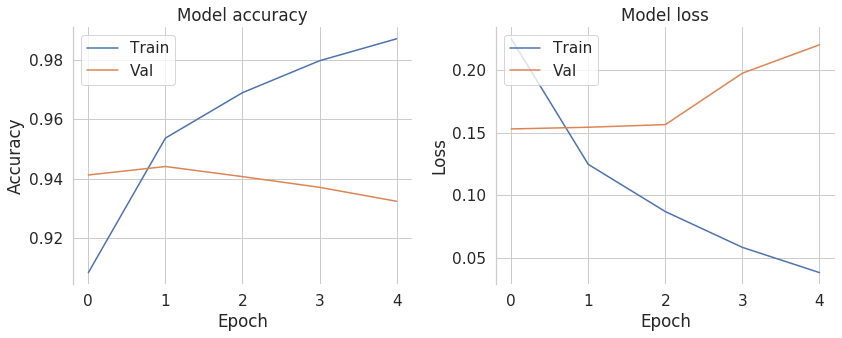

In [36]:
fig = plot_training_curves(history)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/word-vectors/rnn_training.png', dpi=200)

RNN seems to overfit very quickly, but the validation accuracy of the very firsts epoches is quite good !

In [39]:
from sklearn import metrics

probas = model.predict(X_val)
y_pred = (probas > 0.5).astype(np.int)

print("Val Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_val, y_pred)))
print("Val F1-Score: {:.2f}".format(100 * metrics.f1_score(y_val, y_pred)))

Val Accuracy: 93.24
Val F1-Score: 93.26


## Testing

In [37]:
model.load_weights('data/word-vectors/rnn_weights.hdf5')

probas = model.predict(X_test)
y_pred = (probas > 0.5).astype(np.int)

In [41]:
print("Test Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(100 * metrics.f1_score(y_test, y_pred)))
print()

report = metrics.classification_report(
    y_test, y_pred, 
    target_names=class_names.values()
)
print(report)

Test Accuracy: 94.30
Test F1-Score: 94.05

              precision    recall  f1-score   support

    Negative       0.94      0.95      0.95     10408
    Positive       0.94      0.94      0.94      9592

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



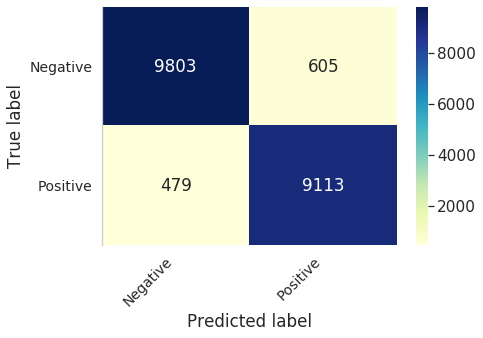

In [180]:
from sklearn.metrics import confusion_matrix
from utils import print_confusion_matrix

conf_mx = confusion_matrix(y_test, y_pred)

fig = print_confusion_matrix(
    conf_mx, 
    class_names.values(), 
    figsize=(7,5)
)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/word-vectors/rnn_test_confusion_mx.png', dpi=200)

## Accuracy vs Training data

In [56]:
sizes = [int(p) for p in np.geomspace(1000, 160000, 10)]
preprocessor = SequencePreprocessor(MAX_NB_WORDS, MAX_LENGTH_SEQ)

test_accuracies = accuracy_vs_training_data(
    model, initial_weights, 
    preprocessor, sizes,
    train_reviews, train_labels,
    val_reviews, val_labels,
    test_reviews, test_labels
)

Train on 1000 samples, validate on 19999 samples
Epoch 1/100
1000/1000 - 6s - loss: 0.6940 - accuracy: 0.4920 - val_loss: 0.6951 - val_accuracy: 0.5102
Epoch 2/100
1000/1000 - 6s - loss: 0.6829 - accuracy: 0.5570 - val_loss: 0.6880 - val_accuracy: 0.5012
Epoch 3/100
1000/1000 - 6s - loss: 0.6274 - accuracy: 0.7120 - val_loss: 0.6632 - val_accuracy: 0.6013
Epoch 4/100
1000/1000 - 6s - loss: 0.2518 - accuracy: 0.9060 - val_loss: 0.7161 - val_accuracy: 0.6734
Epoch 5/100
1000/1000 - 6s - loss: 0.0787 - accuracy: 0.9710 - val_loss: 1.0117 - val_accuracy: 0.7045
Epoch 6/100
Restoring model weights from the end of the best epoch.
1000/1000 - 6s - loss: 0.0153 - accuracy: 0.9940 - val_loss: 1.1572 - val_accuracy: 0.6960
Epoch 00006: early stopping
Train on 1757 samples, validate on 19999 samples
Epoch 1/100
1757/1757 - 7s - loss: 0.6924 - accuracy: 0.5157 - val_loss: 0.6894 - val_accuracy: 0.5478
Epoch 2/100
1757/1757 - 7s - loss: 0.6129 - accuracy: 0.7137 - val_loss: 0.5690 - val_accuracy: 0

In [58]:
import pickle

OUTPUT_PATH = 'data/word-vectors/rnn_accuracies.pickle'

output_dict = {
    "sizes": sizes,
    "test_accuracies": test_accuracies
}

with open(OUTPUT_PATH, 'wb') as writer:
    pickle.dump(output_dict, writer)

## Inference time

In [63]:
model.load_weights('data/word-vectors/rnn_weights.hdf5')

In [64]:
import time

inference_times = []

for i in range(1000):
    x = np.array([X_test[i], ])
    start_time = time.time()
    y_pred = model.predict(x)
    stop_time = time.time()
    
    inference_times.append(stop_time - start_time)    

In [65]:
OUTPUT_PATH = 'data/word-vectors/rnn_times.pickle'

with open(OUTPUT_PATH, 'wb') as writer:
    pickle.dump(inference_times, writer)

## Generalizability

In [71]:
model.load_weights('data/word-vectors/rnn_weights.hdf5')

### Books

In [72]:
X_books, y_books = preprocessor.transform(test_reviews_b, test_labels_b)
evaluate(model, X_books, y_books)

Accuracy: 85.30
F1-Score: 85.37


### DVD

In [73]:
X_dvd, y_dvd = preprocessor.transform(test_reviews_d, test_labels_d)
evaluate(model, X_dvd, y_dvd)

Accuracy: 87.55
F1-Score: 87.95


### Music

In [74]:
X_music, y_music = preprocessor.transform(test_reviews_m, test_labels_m)
evaluate(model, X_music, y_music)

Accuracy: 87.50
F1-Score: 87.60


# CNN

Here we implement [this model](https://arxiv.org/abs/1412.1058), because it has a pretty good accuracy on the english IMDB sentiment analysis dataset.

## Model

In [75]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Embedding, Conv1D, GlobalMaxPooling1D,
                                     BatchNormalization, Dropout, Dense)
from tensorflow.keras.layers import concatenate

# Hyperparameters
embedding_dim = 512
hidden_dim = 512
dropout_rate = 0.05
    
input_layer = tf.keras.layers.Input(shape=(MAX_LENGTH_SEQ,), dtype=tf.int32)

layer = Embedding(MAX_NB_WORDS, output_dim=embedding_dim)(input_layer)

layer_conv3 = Conv1D(hidden_dim, 3, activation="relu")(layer)
layer_conv3 = GlobalMaxPooling1D()(layer_conv3)

layer_conv4 = Conv1D(hidden_dim, 2, activation="relu")(layer)
layer_conv4 = GlobalMaxPooling1D()(layer_conv4)

layer = concatenate([layer_conv4, layer_conv3], axis=1)
layer = BatchNormalization()(layer)
layer = Dropout(dropout_rate)(layer)

output = Dense(1, activation="sigmoid")(layer)

model = Model(name='cnn', inputs=[input_layer], outputs=output)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [48]:
initial_weights = model.get_weights()
model.summary()

Model: "cnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 350, 512)     10240000    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 349, 512)     524800      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 348, 512)     786944      embedding_2[0][0]                
________________________________________________________________________________________________

## Training

In [55]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='data/word-vectors/cnn_weights.hdf5',
    save_best_only=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5, batch_size=128, 
    callbacks=[checkpointer], verbose=1)

Train on 159993 samples, validate on 19999 samples
Epoch 1/5
159872/159993 [============================>.] - ETA: 0s - loss: 0.1972 - accuracy: 0.9205
Epoch 00001: val_loss improved from inf to 0.15284, saving model to data/word-vectors/cnn_weights.hdf5
159993/159993 [==============================] - 218s 1ms/sample - loss: 0.1971 - accuracy: 0.9205 - val_loss: 0.1528 - val_accuracy: 0.9410
Epoch 2/5
159872/159993 [============================>.] - ETA: 0s - loss: 0.0877 - accuracy: 0.9687
Epoch 00002: val_loss did not improve from 0.15284
159993/159993 [==============================] - 219s 1ms/sample - loss: 0.0877 - accuracy: 0.9687 - val_loss: 0.1743 - val_accuracy: 0.9377
Epoch 3/5
159872/159993 [============================>.] - ETA: 0s - loss: 0.0434 - accuracy: 0.9850
Epoch 00003: val_loss did not improve from 0.15284
159993/159993 [==============================] - 223s 1ms/sample - loss: 0.0434 - accuracy: 0.9849 - val_loss: 0.2052 - val_accuracy: 0.9365
Epoch 4/5
159872/1

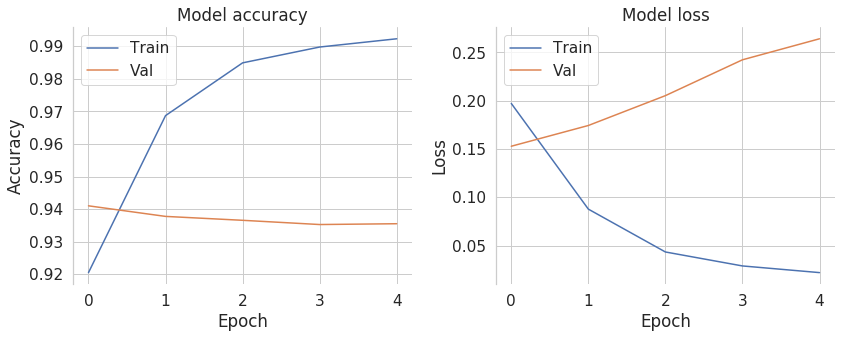

In [56]:
from utils import plot_training_curves

fig = plot_training_curves(history)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/word-vectors/cnn_training.png', dpi=200)

In [57]:
from sklearn import metrics

probas = model.predict(X_val)
y_pred = (probas > 0.5).astype(np.int)

print("Val Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_val, y_pred)))
print("Val F1-Score: {:.2f}".format(100 * metrics.f1_score(y_val, y_pred)))

Val Accuracy: 93.55
Val F1-Score: 93.55


## Testing

In [58]:
model.load_weights('data/word-vectors/cnn_weights.hdf5')
probas = model.predict(X_test)
y_pred = (probas > 0.5).astype(np.int)

In [59]:
print("Test Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(100 * metrics.f1_score(y_test, y_pred)))
print()

report = metrics.classification_report(
    y_test, y_pred, 
    target_names=class_names.values()
)
print(report)

Test Accuracy: 94.12
Test F1-Score: 93.83

              precision    recall  f1-score   support

    Negative       0.94      0.95      0.94     10408
    Positive       0.94      0.93      0.94      9592

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



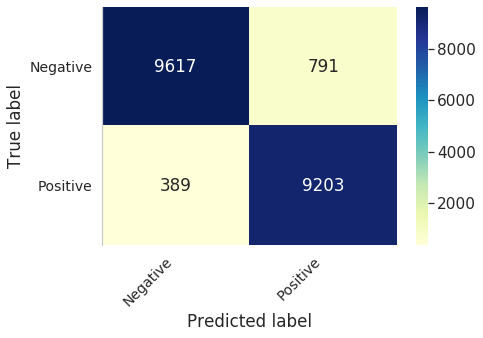

In [45]:
from sklearn.metrics import confusion_matrix
from utils import print_confusion_matrix

conf_mx = confusion_matrix(y_test, y_pred)

fig = print_confusion_matrix(
    conf_mx, 
    class_names.values(), 
    figsize=(7,5)
)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/word-vectors/cnn_test_confusion_mx.png', dpi=200)

## Accuracy vs Training data

In [ ]:
sizes = [1000, 5000, 10000, 20000, 40000, 80000, 120000, 160000]
preprocessor = SequencePreprocessor(MAX_NB_WORDS, MAX_LENGTH_SEQ)

test_accuracies = accuracy_vs_training_data(
    model, initial_weights, 
    preprocessor, sizes,
    train_reviews, train_labels,
    val_reviews, val_labels,
    test_reviews, test_labels
)

In [92]:
import pickle

OUTPUT_PATH = 'data/word-vectors/cnn_accuracies.pickle'

output_dict = {
    "sizes": sizes,
    "test_accuracies": test_accuracies
}

with open(OUTPUT_PATH, 'wb') as writer:
    pickle.dump(output_dict, writer)

## Inference time

In [67]:
model.load_weights('data/word-vectors/cnn_weights.hdf5')

In [68]:
import time

inference_times = []

for i in range(1000):
    x = np.array([X_test[i], ])
    start_time = time.time()
    y_pred = model.predict(x)
    stop_time = time.time()
    
    inference_times.append(stop_time - start_time)    

In [69]:
OUTPUT_PATH = 'data/word-vectors/cnn_times.pickle'

with open(OUTPUT_PATH, 'wb') as writer:
    pickle.dump(inference_times, writer)

## Generalizability

In [76]:
model.load_weights('data/word-vectors/cnn_weights.hdf5')

### Books

In [78]:
X_books, y_books = preprocessor.transform(test_reviews_b, test_labels_b)
evaluate(model, X_books, y_books)

Accuracy: 85.80
F1-Score: 85.66


### DVD

In [79]:
X_dvd, y_dvd = preprocessor.transform(test_reviews_d, test_labels_d)
evaluate(model, X_dvd, y_dvd)

Accuracy: 88.75
F1-Score: 88.90


### Music

In [80]:
X_music, y_music = preprocessor.transform(test_reviews_m, test_labels_m)
evaluate(model, X_music, y_music)

Accuracy: 87.25
F1-Score: 87.68
